In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
## Importing Packages

import os
import torch
import random
import warnings
import numpy as np
import transformers
import pandas as pd 
from PIL import Image
import torch.nn as nn
warnings.filterwarnings("ignore")
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from typing import Callable, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


In [3]:
## Logging into Weights and Biases
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("WANDB_API_KEY")
import wandb
wandb.login(key=api_key);

wandb.init(project="show-and-tell", entity="maknimariem11")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: maknimariem11. Use `wandb login --relogin` to force relogin


In [4]:
plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)


In [6]:
def readImage(path,img_size=224):
    #Predefined Functions from Keras
    #load_img: This function loads an image into PIL (Python Imaging Library) format.
    #img_to_array: Converts a PIL Image instance to a Numpy array
    
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")


# Pre-Processing 🧹

In [7]:
df = pd.read_csv("../input/flickr8k/captions.txt")
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


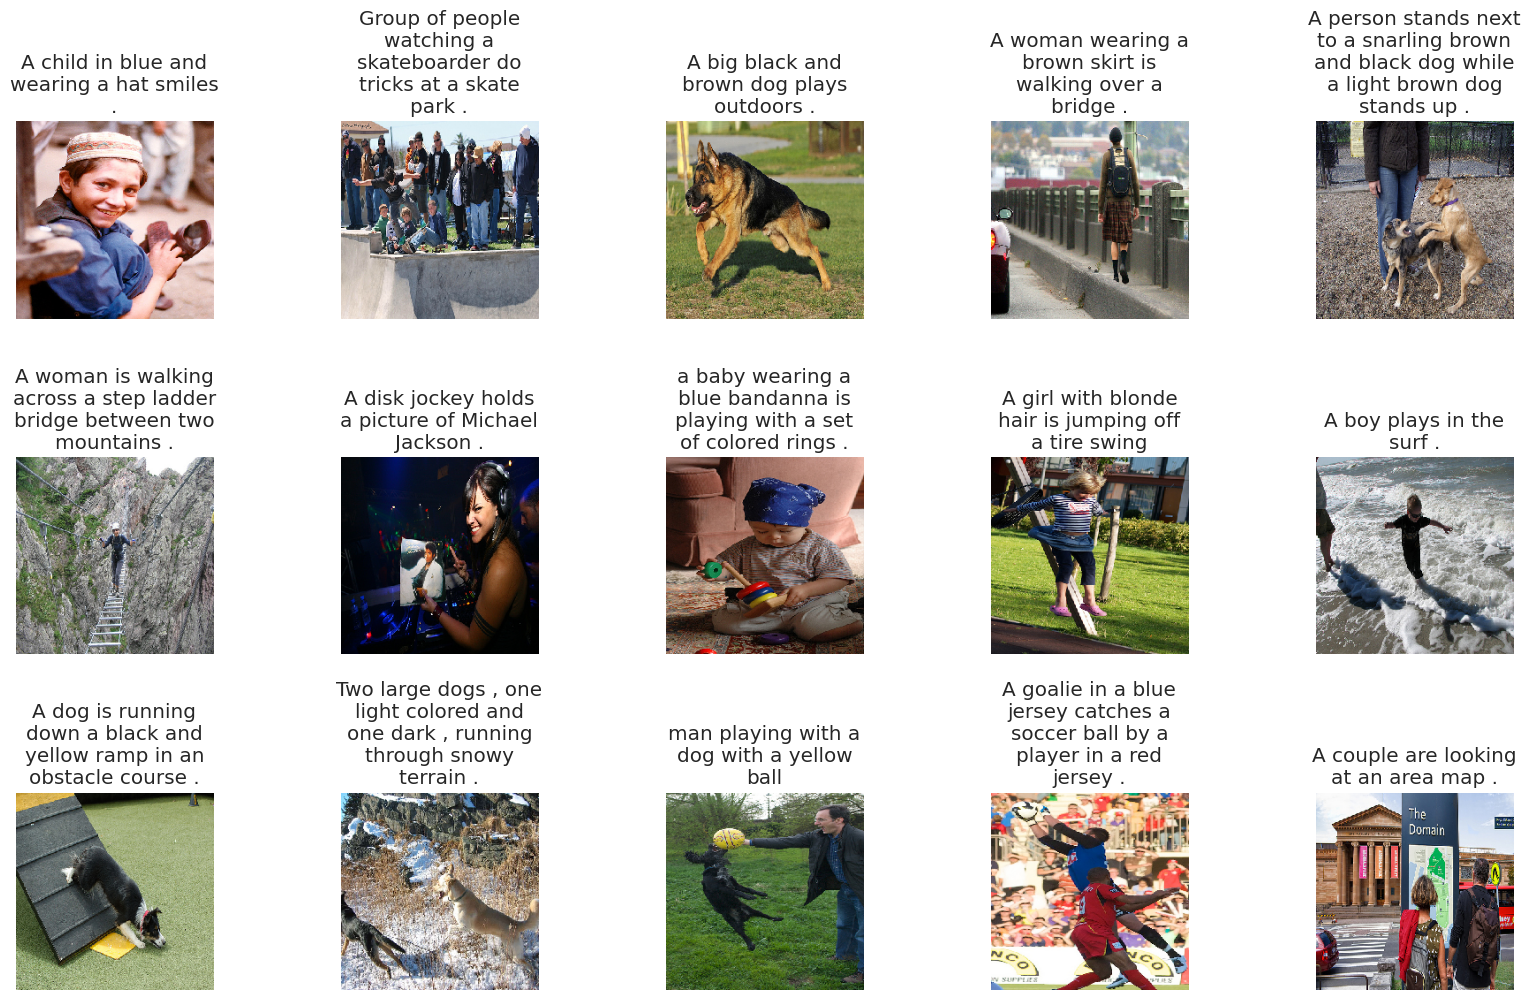

In [8]:
display_images(df.sample(15))
#randomly select 15 rows from the DataFrame 

## TEXT

In [9]:
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


In [10]:
import re
#The string.punctuation constant contains all the punctuation characters
#The str.maketrans() function creates a translation table, 
#which str.translate() then uses to replace the characters specified in the table with None 
def preprocess_captions(captions):
    preprocessed_captions = []
    for caption in captions:
        #Convert sentences into lowercase
        caption = caption.lower()
        #Remove special characters and numbers present in the text
        caption = caption.translate(str.maketrans('', '', string.punctuation + '0123456789'))
        #Remove extra spaces
        caption = re.sub(r'\s+', ' ', caption)
        #Remove single characters
        caption = ' '.join([word for word in caption.split() if len(word) > 1])
        #Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence
        caption = 'startseq ' + caption + ' endseq'
        preprocessed_captions.append(caption)
    return preprocessed_captions

In [11]:
df['preprocessed_caption'] = preprocess_captions(df['caption'])

In [15]:
##### tokenization
#The tokenizer creates a mapping from words to integers
tokenizer = Tokenizer()
#tokenizer.word_index is a dictionary that holds the mapping from words to their integer representation. 
#We add 1 to the size of this dictionary to account for the padding index, which is usually 0. 
tokenizer.fit_on_texts(df['preprocessed_caption'])
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

#Padding captions to max length
max_length = max(len(caption.split()) for caption in df['preprocessed_caption'])
#convert each text in df['preprocessed_caption'] to a sequence of integers.
sequences = tokenizer.texts_to_sequences(df['preprocessed_caption'])
#Padding at the end ('post') is a common choice when working with RNNs because they tend to remember recent inputs better, 
#so padding at the end has less of a chance to interfere with learning the important parts of the sequence.
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')


In [13]:
print(df['preprocessed_caption'][0])
print(padded_sequences[0])

startseq child in pink dress is climbing up set of stairs in an entry way endseq
[   1   41    3   89  168    6  118   52  393   11  390    3   27 5192
  691    2    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


## IMAGE

In [17]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Load the InceptionV3 model pre-trained on ImageNet data, excluding the top classification layer
model = InceptionV3(weights='imagenet', include_top=False)

# Define a function to preprocess a single image
def preprocess_image(image_path, target_size=(224, 224)):
    # Load an image file as a PIL image object, resizing it to target_size
    img = load_img(image_path, target_size=target_size)
    # Convert the PIL image to a numpy array
    img_array = img_to_array(img)
    # Add an additional dimension for the batch size
    img_array = np.expand_dims(img_array, axis=0)
    # Normalize the image array
    img_array = preprocess_input(img_array)
    return img_array

# Define a function to preprocess multiple images
def preprocess_images(image_paths, target_size=(224, 224)):
    # Initialize an array to hold the preprocessed images
    images_array = np.zeros((len(image_paths), target_size[0], target_size[1], 3))
    # Loop over all image paths
    for idx, image_path in enumerate(image_paths):
        # Preprocess each individual image
        img_array = preprocess_image(image_path, target_size)
        # Store the preprocessed image in the array
        images_array[idx] = img_array[0]  # remove batch dimension
    return images_array

# Assuming 'data' is your DataFrame and it has a column 'image' with the filenames
image_paths = ['../input/flickr8k/Images/' + image_name for image_name in df['image'].unique().tolist()]

# Preprocess all images
preprocessed_images = preprocess_images(image_paths)

# Now, preprocessed_images is ready for feature extraction or as input to your model


In [ ]:
import matplotlib.pyplot as plt
from textwrap import wrap

# Adjusted display_images function to work with a NumPy array of images
def display_images2(image_array, captions, num_images=15):
    plt.figure(figsize=(20, 20))
    
    for i in range(min(len(image_array), num_images)):  # Limit to num_images or the length of the array
        
        plt.subplot(5, 5, i+1)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        plt.imshow(image_array[i])  # Display the i-th image from the array
        if captions is not None:
            plt.title("\n".join(wrap(captions[i], 20)))
        plt.axis("off")
    plt.show()


In [ ]:
#display_images(df.sample(15))

display_images2(preprocessed_images.sample(15),df['preprocessed_caption'],15)

In [21]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, GlobalAveragePooling2D
from keras.applications import VGG16
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Step 1: Create the CNN model
def create_cnn_model():
    # Load a pre-trained CNN model without the top classification layer
    cnn_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    # Add new layers on top of the CNN
    new_output = GlobalAveragePooling2D()(cnn_model.output)
    # Create a new model with the new output layer
    cnn_model = Model(inputs=cnn_model.input, outputs=new_output)
    # Set the CNN layers to non-trainable (weights will not be updated)
    for layer in cnn_model.layers:
        layer.trainable = False
    return cnn_model

# Step 2: Create the LSTM model
def create_lstm_model(vocab_size, max_length, cnn_output_size=512):  # Change cnn_output_size to 512
    # Image feature extractor model
    inputs1 = Input(shape=(cnn_output_size,)) 
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    # Sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    
    # Decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # Tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

# Now we can create our CNN and LSTM models
cnn_model = create_cnn_model()
lstm_model = create_lstm_model(vocab_size, max_length, cnn_output_size=512)  # Assuming InceptionV3 output size is 512


58889256/58889256 [==============================] - 3s 0us/step


In [22]:
id_to_word = {v: k for k, v in tokenizer.word_index.items()}

In [23]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model
import numpy as np

# Load VGG16 model, excluding the top classification layer
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Create a new model that will output the features from the VGG16 convolutional base
feature_model = Model(inputs=vgg_model.input, outputs=vgg_model.output)

def extract_features(image_paths, model):
    features = {}
    for image_path in image_paths:
        # Load the image file, resizing it to 224x224 pixels (input size of VGG16)
        img = load_img(image_path, target_size=(224, 224))
        # Convert the image to a numpy array and preprocess it for VGG16
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        # Extract features
        feature = model.predict(img_array)
        # Flatten the features to a one-dimensional array
        feature = feature.flatten()
        # Retrieve the image id (assuming the image path format is consistent and ends with the id)
        image_id = image_path.split('/')[-1]
        features[image_id] = feature
    return features

# Assuming 'image_paths' is a list of all image file paths
image_features = extract_features(image_paths, feature_model)

# Now 'image_features' is a dictionary mapping image ids to their extracted feature vectors


1/1 [==============================] - 0s 296ms/step


KeyboardInterrupt: 

In [24]:
test_image = preprocess_image('../input/flickr8k/Images/1000268201_693b08cb0e.jpg')
# Extract image features using cnn_model
image_features = cnn_model.predict(test_image)

# Initialize caption sequence
caption = ['<startseq>']

# Generate captions
max_caption_length = 20  # Adjust as needed
for _ in range(max_caption_length):
    # Tokenize the current caption sequence and convert it to input format
    sequence = tokenizer.texts_to_sequences([caption])[0]
    sequence = pad_sequences([sequence], maxlen=max_length)

    # Predict the next word using lstm_model
    next_word_id = lstm_model.predict([image_features, sequence]).argmax()

    # Convert the next word ID to a word and add it to the caption
    next_word = id_to_word.get(next_word_id, '')  # Get the word or return an empty string if ID not found
    caption.append(next_word)
    
    if next_word == 'endseq':
        break
# Post-process the generated caption
generated_caption = ' '.join(caption[1:-1])  # Remove start and end tokens

# Print or store the generated caption for analysis or further use
print("Generated Caption:", generated_caption)

1/1 [==============================] - 0s 33ms/step
Generated Caption: hauling hauling hauling hauling hauling hauling hauling hauling hauling hauling hauling hauling hauling hauling hauling hauling hauling hauling hauling


In [26]:
# Create a mapping from image names to their indices in the preprocessed_images array
image_name_to_index = {name: idx for idx, name in enumerate(df['image'].unique())}

# Function to get the preprocessed image numpy array from image name
def get_preprocessed_image(image_name):
    index = image_name_to_index[image_name]
    return preprocessed_images[index]

# Example usage
test_image_name = '1000268201_693b08cb0e.jpg'  # Replace with any image name from your dataset
test_image_array = get_preprocessed_image(test_image_name)

# Now you can use test_image_array for prediction with your model


In [27]:
def display_images3(image_data, captions, num_images=15):
    # Check if the input is a single image by checking the number of dimensions
    if image_data.ndim == 3:
        # We have a single image, so wrap it in a list so we can display it
        image_list = [image_data]
    else:
        # We have an array or list of images
        image_list = image_data

    plt.figure(figsize=(20, 20))
    for i in range(min(len(image_list), num_images)):  # Limit to num_images or the length of the array
        plt.subplot(5, 5, i+1)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        plt.imshow(image_list[i])  # Display the i-th image from the list
        if captions is not None:
            plt.title("\n".join(wrap(captions[i], 20)))
        plt.axis("off")
    plt.show()
